In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


data = pd.read_csv('facies_vectors.csv')
train_wells = data[data['Well Name'] != "SHANKLE"]
test_well = data[data['Well Name'] == "SHANKLE"]

y_train = train_wells.drop(['Facies', 'Formation', 'Well Name', 'Depth', 'NM_M', 'RELPOS'], axis=1)
y_test = test_well['Facies']


In [103]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
import sklearn.svm
%matplotlib inline

# import file
data = pd.read_csv('facies_vectors.csv')
print(data['Well Name'].unique())

# fill NaN with the mean value
data.fillna(data['PE'].mean(), inplace=True)

# create a raining wells set of data (without test well)
training_wells = data[data['Well Name'] != 'SHANKLE']

# create a test well set of data
test_well = data[data['Well Name'] == 'SHANKLE']

# unique training well names
well_names = list(training_wells['Well Name'].unique())

# create a list of features from training wells (without Facies)
X_train = np.array(training_wells.drop(['Facies', 'Formation', 'Well Name', 
                                        'Depth'], 1))
#X_train = preprocessing.scale(X_train)

# create a label from training wells (Facies)
y_train = np.array(training_wells['Facies'])

# create a list of features from test well (without Facies)
X_test = np.array(test_well.drop(['Facies', 'Formation', 'Well Name', 
                                  'Depth'], axis=1))
#X_test = preprocessing.scale(X_test)

# create a label from test well (Facies)
y_test = np.array(test_well['Facies'])

models = []
models.append(('Lin_Reg', LinearRegression()))
models.append(('Log_Reg', LogisticRegression()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('GNB', GaussianNB()))
models.append(('BR', BayesianRidge()))
models.append(('CLF', SVC()))
models.append(('REG', SVR()))
names = []
results = []

for name, model in models:
    model.fit(X_train, y_train)
    names.append(name)
    results.append(model.score(X_test, y_test))

for i in range(len(names)):
    print("%s: %s" % (names[i], results[i]))

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']
Lin_Reg: 0.855793988736
Log_Reg: 0.463251670379
DTC: 0.405345211581
KNC: 0.41425389755
LDA: 0.550111358575
GNB: 0.391982182628
BR: 0.85568121519
CLF: 0.483296213808
REG: 0.647914795849


In [109]:
BR = BayesianRidge()
BR.fit(X_train, y_train)
prediction_BR = Lin_Reg.predict(X_test)

test_well['Prediction'] = prediction_BR

AttributeError: 'BayesianRidge' object has no attribute 'scale'

In [90]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']

facies_color_map = dict(zip(facies_labels, facies_colors))

In [91]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Bayesian Ridge accuracy is: 0.855698151574


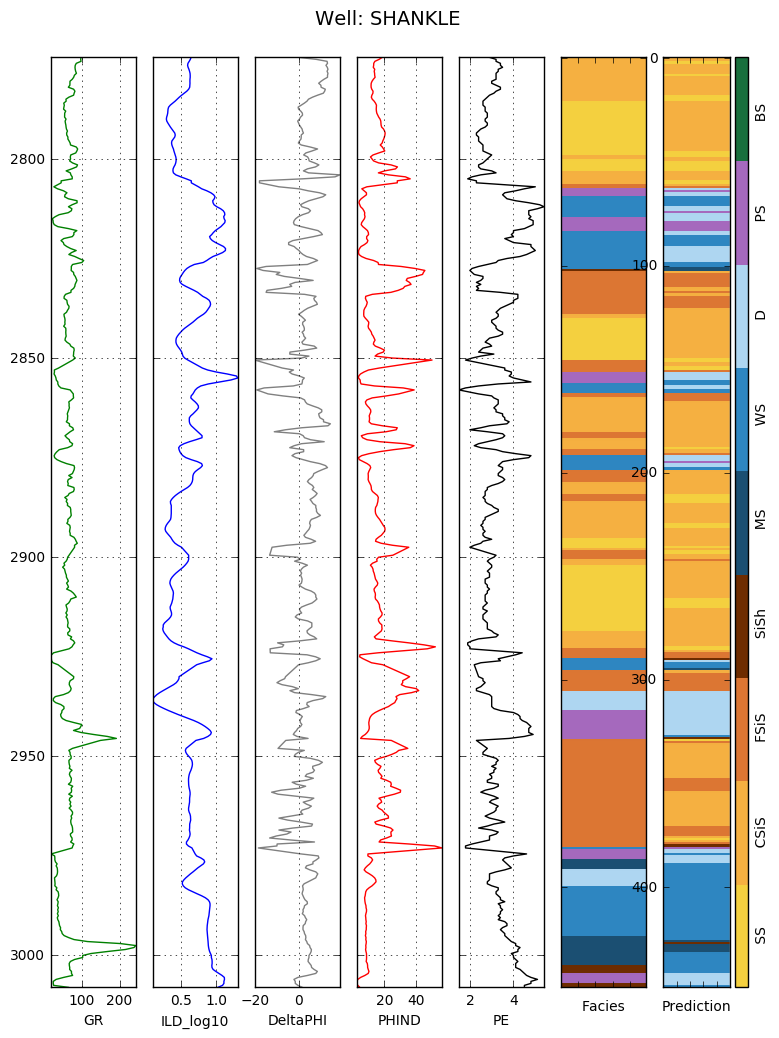

In [114]:
print('Bayesian Ridge accuracy is:', BR.score(X_test, y_test))
compare_facies_plot(test_well, 'Prediction', facies_colors)

#### Modeled in cooperation with Ievgen Ustenko
Github: https://github.com/iUstenko |
LinkedIn: https://goo.gl/gfRoSc